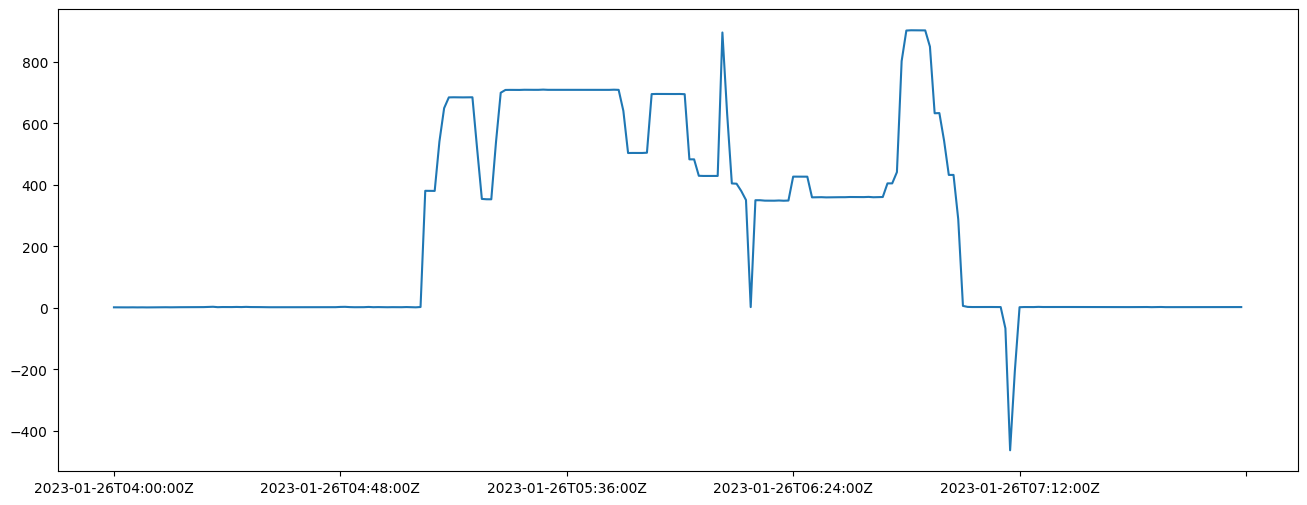

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import HourLocator, DateFormatter
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from influxdb import InfluxDBClient

# Connect to InfluxDB and fetch data
client = InfluxDBClient(host='localhost', port=8086)
client.switch_database('ISS')
query = 'SELECT * FROM "EP_Propulsion1.Thing_HMD8310" WHERE time >= \'2023-01-26T04:00:00Z\' AND time < \'2023-01-26T08:00:00Z\''
results = client.query(query)
df_train = pd.DataFrame.from_records(results.get_points())

# Convert MotorRPM column to numeric
df_train['MotorRPM'] = pd.to_numeric(df_train['MotorRPM'])

# Set up the plot
fig, ax = plt.subplots(figsize=(16, 6))

# Plot the data
ax.plot(df_train['time'], df_train['MotorRPM'])
total_len = len(df_train.index)
ax.set_xticks(np.arange(0, total_len + 1, total_len / 5))

plt.show()

In [58]:
# Split the data into train and test sets
train_data = df_train.loc[:, ['MotorRPM']]

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(train_data)

# Define the autoencoder model
input_layer = Input(shape=(X_train.shape[1],))
encoder_layer = Dense(4, activation='relu')(input_layer)
decoder_layer = Dense(X_train.shape[1], activation='linear')(encoder_layer)
autoencoder = Model(input_layer, decoder_layer)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Train the model
autoencoder.fit(X_train, X_train, epochs=100, batch_size=32, verbose=0)

# Fetch the test data
query = 'SELECT * FROM "EP_Propulsion1.Thing_HMD8310" WHERE time >= \'2023-02-02T04:00:00Z\' AND time < \'2023-02-02T08:00:00Z\''
results = client.query(query)
df_test = pd.DataFrame.from_records(results.get_points())

# Convert MotorRPM column to numeric
df_test['MotorRPM'] = pd.to_numeric(df_test['MotorRPM'])

# Predict the MotorRPM values for the test dataset
X_test = scaler.transform(df_test.loc[:, ['MotorRPM']])
y_pred = autoencoder.predict(X_test)

# Calculate the mean squared error
mse = np.mean(np.power(X_test - y_pred, 2), axis=1)


8/8 [==============================] - 0s 726us/step


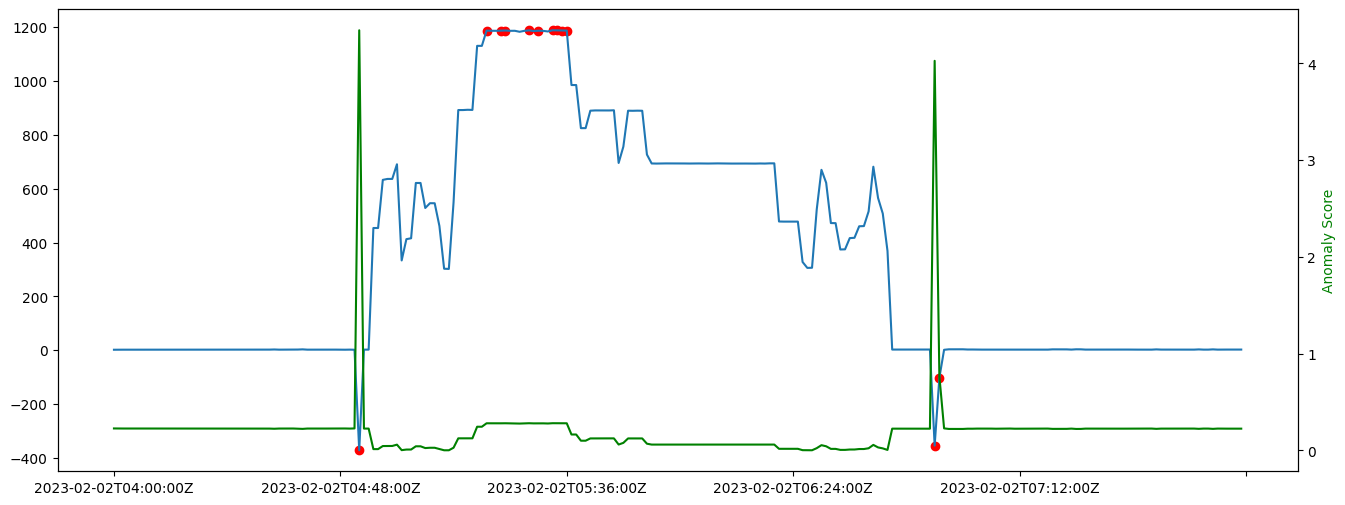

In [59]:

# Define the anomaly threshold
threshold = np.percentile(mse, 95)

# Mark the anomalies
df_test['anomaly'] = mse > threshold

# Set up the plot
fig, ax = plt.subplots(figsize=(16, 6))

# Plot the data and the anomalies
ax.plot(df_test['time'], df_test['MotorRPM'])
ax.scatter(df_test.loc[df_test['anomaly'], 'time'], df_test.loc[df_test['anomaly'], 'MotorRPM'], color='red')
total_len = len(df_test.index)
ax.set_xticks(np.arange(0, total_len + 1, total_len / 5))

# Display the anomaly score on the chart
ax2 = ax.twinx()
ax2.plot(df_test['time'], mse, color='green')
ax2.set_ylabel('Anomaly Score', color='green')

plt.show()